# Fitting the Barnes Gyro relation using a Gaussian Process fit in age

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import warnings
import matplotlib.gridspec as gridspec
import mystyle as ms
import pandas as pd

warnings.filterwarnings('ignore')

$P = \tau^a \times b(BP - RP - c)^d$

where $P$ is rotation in days
$\tau$ is age (in Myr),
B-V are colour in magnitude,
the rest are free parameters


The uncertainties on age and period are heteroskedastic. The uncertainties on $BP-RP$ are small that we can assume them to be homoskedastic.

We'll use:
- A latent parameter treatment of the $BP-RP$ uncertainties.
- A latent parameter treatment of the $\tau$ uncertainties.
- A Gaussian Process treatment of the $P$ uncertainties that is generated from the latent parameters for $BP-RP$ and $\tau$ and is a function of separation in $\tau$ only.

In [2]:
latent = [0.5380376085895715, 0.5659898043933116, 0.321367381257116, 1.7055924587446913]

def gyro(tau, bprp, a, b, c, d):
    return (tau*1000)**a * b*(bprp - c)**d

In [3]:
ati = pd.read_csv('../data/atium.csv',index_col=0)
ati = ati[np.isfinite(ati.P.values)]   #Exclude stars without results
ati = ati[ati.chainflag < 1]            #Exclude stars without well constrained results
ati = ati[ati.KIC != 7680114]          #Exclude star that is clearly unevolved
ati = ati[np.isfinite(ati.ebprp.values)] #Exclude star with nan bprp
print('We have {} stars'.format(len(ati)))

We have 48 stars


In [4]:
period_obs = ati.P.values
sigma_p = (ati.l_P.values + ati.u_P.values)/2

age_obs = ati.age.values
sigma_age = (ati.loage.values + ati.upage.values)/2

bprp_obs = ati.bprp.values
sigma_bprp = ati.ebprp.values

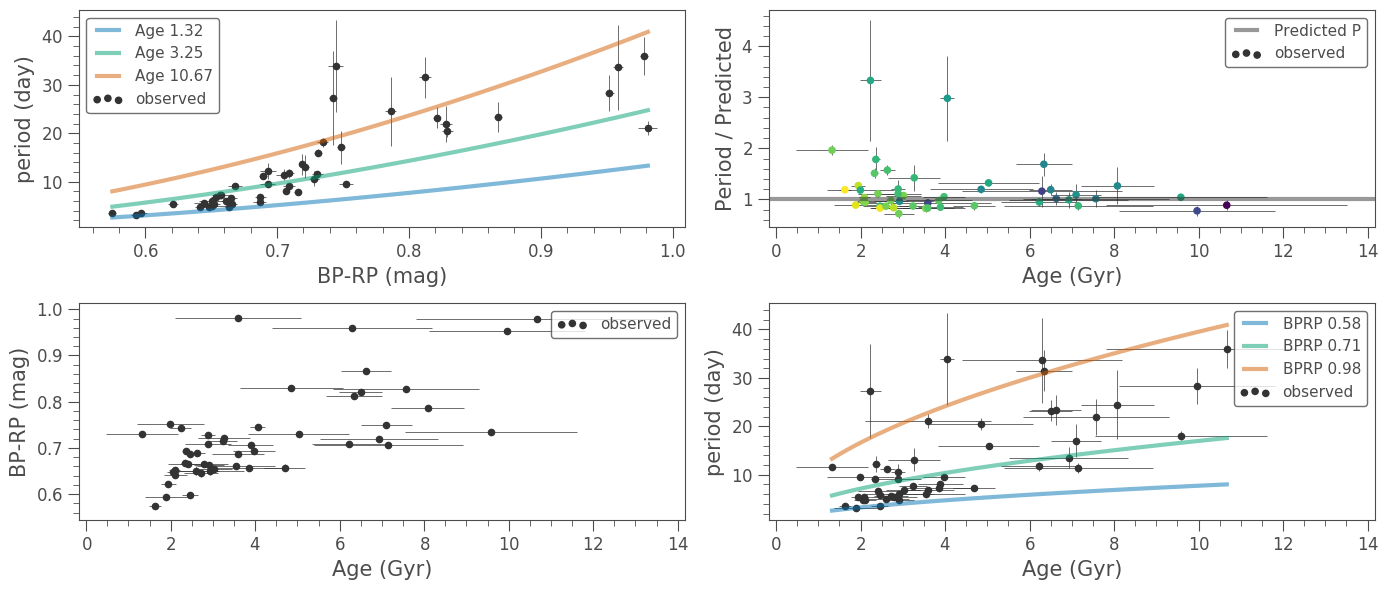

In [13]:
with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
    ax0.scatter(bprp_obs, period_obs,zorder=1, s=20, label='observed')
    ax0.errorbar(bprp_obs, period_obs, yerr=sigma_p, xerr=sigma_bprp, fmt='|',zorder=0)
    ax0.set_xlabel('BP-RP (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
    ax1.scatter(age_obs, period_obs,zorder=1, s=20, label='observed')
    ax1.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
    ax2.scatter(age_obs, bprp_obs,zorder=1, s=20, label='observed')
    ax2.errorbar(age_obs, bprp_obs, yerr=sigma_bprp, xerr=sigma_age, fmt='|',zorder=0)
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('BP-RP (mag)')
    ax2.legend()    
    
    ax3 = plt.subplot(gs[0,1])
    den = gyro(age_obs, bprp_obs, *latent)
    ax3.scatter(age_obs, period_obs / den,
                c=ati.Teff ,zorder=1, s=20, label='observed')
    ax3.errorbar(age_obs, period_obs / den, yerr=sigma_p/den, xerr=sigma_age, fmt='|',zorder=0)

    ax3.axhline(1., label='Predicted P', lw=3, alpha=.5)
    ax3.set_xlabel('Age (Gyr)')
    ax3.set_ylabel('Period / Predicted')
    ax3.legend()    
    
    
    agex = np.linspace(age_obs.min(), age_obs.max(), 100)
    ax1.plot(agex, gyro(agex, bprp_obs.min(), *latent), label='BPRP {:.2f}'.format(bprp_obs.min()), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, np.mean(bprp_obs), *latent), label='BPRP {:.2f}'.format(np.median(bprp_obs)), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, bprp_obs.max(), *latent), label='BPRP {:.2f}'.format(bprp_obs.max()), 
             lw=3, alpha=.5)    
    ax1.legend()
    
    bprpx = np.linspace(bprp_obs.min(), bprp_obs.max(), 100)
    ax0.plot(bprpx, gyro(age_obs.min(), bprpx, *latent), label='Age {:.2f}'.format(age_obs.min()), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(np.mean(age_obs), bprpx, *latent), label='Age {:.2f}'.format(np.median(age_obs)), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(age_obs.max(), bprpx, *latent), label='Age {:.2f}'.format(age_obs.max()), 
             lw=3, alpha=.5)    
    ax0.legend()    
    
    fig.tight_layout()
    plt.show()

Now lets fit for Period using a latent parameter model

In [24]:
gpfit = '''
data {
    int<lower=1> N;
    real<lower=0> P[N];
    real<lower=0> sigma_p[N];
    
    real bprp[N];
    real<lower=0> sigma_bprp[N];
    
    real<lower=0> age[N];
    real<lower=0> sigma_age[N];
}
transformed data{
    real delta = 1e-9;
}
parameters {
    real<lower=0> alpha;
    real<lower=0> rho;

    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> c;
    real<lower=0> d;
    
    vector[N] eta;
    real raw_bprp[N];
    real raw_age[N];
}
transformed parameters {
    vector[N] f;
    real<lower=0> true_age[N];
    real true_bprp[N];
    vector<lower=0>[N] mu;
    
    for (n in 1:N){
        true_age[n] = sigma_age[n] * raw_age[n] + age[n];
        true_bprp[n] = sigma_bprp[n] * raw_bprp[n] + bprp[n];
        mu[n] = (true_age[n]*1000)^a * b * (true_bprp[n] - c)^d;
    }
    {
        matrix[N, N] L_K;
        matrix[N, N] K = cov_exp_quad(true_age, alpha, rho);
        
        for (n in 1:N){
            K[n, n] = K[n, n] + delta;
        }
        
        L_K = cholesky_decompose(K);
        f = mu + L_K * eta;
    }
}
model {
    rho ~ inv_gamma(1, 1);
    alpha ~ std_normal();

    a ~ normal(0.54, .5);
    b ~ normal(0.65, .5);
    c ~ normal(0.32, .5);
    d ~ normal(1.71, .5);
    
    raw_bprp ~ std_normal(); // implies true_bprp ~ normal(bprp, sigma_bprp)
    raw_age ~ std_normal();  // implies true_age ~ normal(age, sigma_age)
    eta ~ std_normal();      // implies P ~ multi_normal(mu, Sigma)

    P ~ normal(f, sigma_p);
}
'''
sm = pystan.StanModel(model_code = gpfit, model_name='gpfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gpfit_3a014c9e587312b9cc48f5c65daf2fb2 NOW.


In [25]:
data = {'N' : len(period_obs),
       'P' : period_obs,
       'sigma_p' : sigma_p,
       'bprp' : bprp_obs,
       'sigma_bprp' : sigma_bprp,
       'age' : age_obs,
       'sigma_age' : sigma_age}

init = {'a' : latent[0],
        'b' : latent[1],
        'c' : latent[2],
        'd' : latent[3],
        'alpha' : .1,
        'rho' : 1.,
        'true_age' : age_obs,
        'true_bprp' : bprp_obs}

In [ ]:
fit = sm.sampling(data=data, iter=10000, chains=4, seed=11,
                  init = [init for n in range(4)])

In [ ]:
print(fit)

In [ ]:
fit.plot()
plt.show()

In [ ]:
import corner
labels=['a','b','c','d', 'alpha', 'rho']
verbose=['a','b','c','d', r'$\alpha$', r'$\rho$']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, 
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

In [ ]:
import matplotlib.gridspec as gridspec
import mystyle as ms
import seaborn as sns

def gyro(tau, bprp, a, b, c, d):
    return (tau*1000)**a * b*(bprp - c)**d

gyrores = [np.median(fit[label]) for label in ['a','b','c','d']]

with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
    ax0.scatter(bprp_obs, period_obs,zorder=1, s=20, label='observed')
    ax0.errorbar(bprp_obs, period_obs, yerr=sigma_p, xerr=sigma_bprp, fmt='|',zorder=0)
    ax0.set_xlabel('BP-RP (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
    ax1.scatter(age_obs, period_obs,zorder=1, s=20, label='observed')
    ax1.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
    ax2.scatter(age_obs, bprp_obs,zorder=1, s=20, label='observed')
    ax2.errorbar(age_obs, bprp_obs, yerr=sigma_bprp, xerr=sigma_age, fmt='|',zorder=0)
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('BP-RP (mag)')
    ax2.legend()    
    
    ax3 = plt.subplot(gs[0,1])
    sns.distplot((np.median(fit['true_age'],axis=0) - age_obs)/age_obs, ax=ax3, label='Age')
#     sns.distplot((np.median(fit['true_bprp'],axis=0) - bprp_obs)/bprp_obs, ax=ax3, label='BPRP')
    sns.distplot((gyro(np.median(fit['true_age'],axis=0), np.median(fit['true_bprp'],axis=0),
                     *gyrores) - period_obs)/period_obs, ax=ax3, label='Period')
    ax3.set_xlabel('latent % difference (BPRP negligible)')
    ax3.legend()

    
    agex = np.linspace(age_obs.min(), age_obs.max(), 100)
    ax1.plot(agex, gyro(agex, bprp_obs.min(), *gyrores), label='BPRP {:.2f}'.format(bprp_obs.min()), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, np.mean(bprp_obs), *gyrores), label='BPRP {:.2f}'.format(np.median(bprp_obs)), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, bprp_obs.max(), *gyrores), label='BPRP {:.2f}'.format(bprp_obs.max()), 
             lw=3, alpha=.5)    
    ax1.legend()
    
    bprpx = np.linspace(bprp_obs.min(), bprp_obs.max(), 100)
    ax0.plot(bprpx, gyro(age_obs.min(), bprpx, *gyrores), label='Age {:.2f}'.format(age_obs.min()), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(np.mean(age_obs), bprpx, *gyrores), label='Age {:.2f}'.format(np.median(age_obs)), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(age_obs.max(), bprpx, *gyrores), label='Age {:.2f}'.format(age_obs.max()), 
             lw=3, alpha=.5)    
    ax0.legend()    
    
    fig.tight_layout()
    plt.show()

This looks like a tidy fit good enough for a poster!